# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

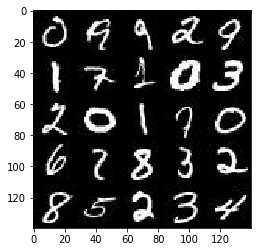

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

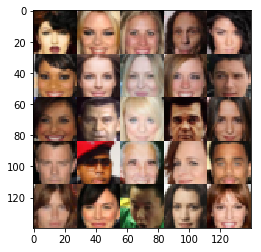

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
alpha = 0.2

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        #print(x1.get_shape().as_list())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        #print(x2.get_shape().as_list())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #print (x3.get_shape().as_list())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        ## 16x16x64 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        #print (x4.get_shape().as_list())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        ## 16x16x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)       
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    images_fake = generator(input_z, out_channel_dim, True)
        
    d_model_real, d_logits_real = discriminator(input_real, False)    
    d_model_fake, d_logits_fake = discriminator(images_fake, True)
    
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
print_every = 10
show_every = 200
no_display_images = 20
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()  
    if data_image_mode == 'RGB':
        out_channel_dim = 3        
    else:
        out_channel_dim = 1

    input_real, input_z, l_r = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)            
    d_opt, g_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    steps = 0
    losses = []    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2;

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_r: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:                    
                    show_generator_output(sess, no_display_images, input_z, out_channel_dim, data_image_mode)
                    
        show_generator_output(sess, no_display_images, input_z, out_channel_dim, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.0574... Generator Loss: 4.3934
Epoch 0/2... Discriminator Loss: 0.0040... Generator Loss: 6.9636
Epoch 0/2... Discriminator Loss: 0.2468... Generator Loss: 2.0777
Epoch 0/2... Discriminator Loss: 1.3493... Generator Loss: 0.3529
Epoch 0/2... Discriminator Loss: 0.0561... Generator Loss: 8.7780
Epoch 0/2... Discriminator Loss: 2.2878... Generator Loss: 0.1894
Epoch 0/2... Discriminator Loss: 0.3320... Generator Loss: 2.4869
Epoch 0/2... Discriminator Loss: 0.4281... Generator Loss: 1.7446
Epoch 0/2... Discriminator Loss: 0.7099... Generator Loss: 1.9531
Epoch 0/2... Discriminator Loss: 0.1305... Generator Loss: 2.5474
Epoch 0/2... Discriminator Loss: 0.8686... Generator Loss: 0.8045
Epoch 0/2... Discriminator Loss: 0.3254... Generator Loss: 7.1639
Epoch 0/2... Discriminator Loss: 1.2151... Generator Loss: 0.6636
Epoch 0/2... Discriminator Loss: 0.1364... Generator Loss: 3.0572
Epoch 0/2... Discriminator Loss: 3.9548... Generator Loss: 0.0337
Epoch 0/2.

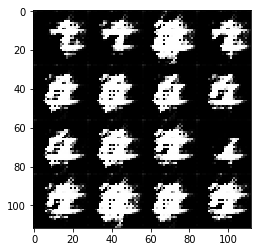

Epoch 0/2... Discriminator Loss: 0.0889... Generator Loss: 3.5173
Epoch 0/2... Discriminator Loss: 0.6143... Generator Loss: 0.9445
Epoch 0/2... Discriminator Loss: 0.9224... Generator Loss: 0.6273
Epoch 0/2... Discriminator Loss: 0.5635... Generator Loss: 1.6297
Epoch 0/2... Discriminator Loss: 0.7781... Generator Loss: 1.3939
Epoch 0/2... Discriminator Loss: 0.6503... Generator Loss: 1.1697
Epoch 0/2... Discriminator Loss: 0.8497... Generator Loss: 0.8169
Epoch 0/2... Discriminator Loss: 0.8011... Generator Loss: 0.8959
Epoch 0/2... Discriminator Loss: 0.3789... Generator Loss: 2.1713
Epoch 0/2... Discriminator Loss: 1.0553... Generator Loss: 2.9864
Epoch 0/2... Discriminator Loss: 1.5484... Generator Loss: 0.3822
Epoch 0/2... Discriminator Loss: 1.0368... Generator Loss: 0.8789
Epoch 0/2... Discriminator Loss: 0.8218... Generator Loss: 0.9555
Epoch 0/2... Discriminator Loss: 1.5219... Generator Loss: 0.3277
Epoch 0/2... Discriminator Loss: 0.7624... Generator Loss: 0.9322
Epoch 0/2.

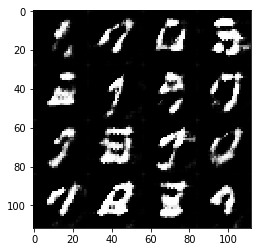

Epoch 0/2... Discriminator Loss: 1.0170... Generator Loss: 0.8281
Epoch 0/2... Discriminator Loss: 1.3031... Generator Loss: 1.0204
Epoch 0/2... Discriminator Loss: 0.7957... Generator Loss: 1.0288
Epoch 0/2... Discriminator Loss: 0.7221... Generator Loss: 1.3356
Epoch 0/2... Discriminator Loss: 0.9195... Generator Loss: 0.7892
Epoch 0/2... Discriminator Loss: 0.8639... Generator Loss: 1.1046
Epoch 0/2... Discriminator Loss: 1.3072... Generator Loss: 0.4564
Epoch 0/2... Discriminator Loss: 2.0380... Generator Loss: 0.2431
Epoch 0/2... Discriminator Loss: 1.6453... Generator Loss: 0.3164
Epoch 0/2... Discriminator Loss: 1.1694... Generator Loss: 0.5320
Epoch 0/2... Discriminator Loss: 1.4451... Generator Loss: 0.3717
Epoch 0/2... Discriminator Loss: 1.1295... Generator Loss: 0.7982
Epoch 0/2... Discriminator Loss: 1.3700... Generator Loss: 1.1629
Epoch 0/2... Discriminator Loss: 0.7189... Generator Loss: 1.3956
Epoch 0/2... Discriminator Loss: 1.1213... Generator Loss: 0.5741
Epoch 0/2.

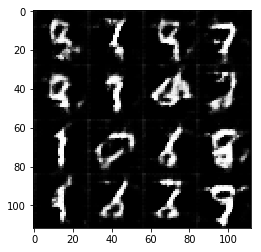

Epoch 0/2... Discriminator Loss: 1.3094... Generator Loss: 0.4402
Epoch 0/2... Discriminator Loss: 0.8003... Generator Loss: 1.2521
Epoch 0/2... Discriminator Loss: 1.8062... Generator Loss: 0.2831
Epoch 0/2... Discriminator Loss: 0.7717... Generator Loss: 1.0416
Epoch 0/2... Discriminator Loss: 1.7233... Generator Loss: 0.6166
Epoch 0/2... Discriminator Loss: 0.7907... Generator Loss: 1.0183
Epoch 0/2... Discriminator Loss: 2.3457... Generator Loss: 0.1757
Epoch 0/2... Discriminator Loss: 1.2416... Generator Loss: 0.4416
Epoch 0/2... Discriminator Loss: 0.9313... Generator Loss: 0.9134
Epoch 0/2... Discriminator Loss: 0.7981... Generator Loss: 1.6993
Epoch 0/2... Discriminator Loss: 1.6958... Generator Loss: 0.3411
Epoch 0/2... Discriminator Loss: 1.0888... Generator Loss: 0.8942
Epoch 0/2... Discriminator Loss: 1.0827... Generator Loss: 2.3858
Epoch 0/2... Discriminator Loss: 1.4824... Generator Loss: 1.3999
Epoch 0/2... Discriminator Loss: 1.4488... Generator Loss: 0.4089
Epoch 0/2.

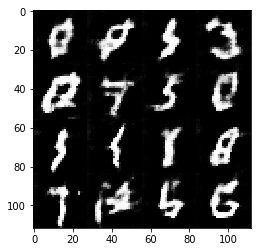

Epoch 0/2... Discriminator Loss: 1.0761... Generator Loss: 2.2927
Epoch 0/2... Discriminator Loss: 0.8206... Generator Loss: 1.1658
Epoch 0/2... Discriminator Loss: 1.3063... Generator Loss: 0.9150
Epoch 0/2... Discriminator Loss: 0.6672... Generator Loss: 1.2735
Epoch 0/2... Discriminator Loss: 1.9384... Generator Loss: 0.2048
Epoch 0/2... Discriminator Loss: 1.1507... Generator Loss: 0.4904
Epoch 0/2... Discriminator Loss: 0.9716... Generator Loss: 0.7257
Epoch 0/2... Discriminator Loss: 1.4224... Generator Loss: 1.3077
Epoch 0/2... Discriminator Loss: 0.8050... Generator Loss: 1.4870
Epoch 0/2... Discriminator Loss: 2.5663... Generator Loss: 0.1034
Epoch 0/2... Discriminator Loss: 2.5219... Generator Loss: 0.1134
Epoch 0/2... Discriminator Loss: 1.4344... Generator Loss: 0.3609
Epoch 0/2... Discriminator Loss: 1.3414... Generator Loss: 0.4470
Epoch 0/2... Discriminator Loss: 1.5085... Generator Loss: 0.7230
Epoch 0/2... Discriminator Loss: 0.7243... Generator Loss: 1.0357
Epoch 0/2.

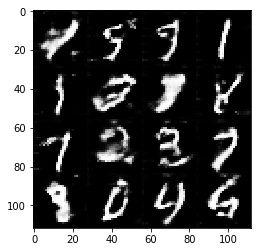

Epoch 0/2... Discriminator Loss: 0.9602... Generator Loss: 1.0773
Epoch 0/2... Discriminator Loss: 1.2296... Generator Loss: 0.5203
Epoch 0/2... Discriminator Loss: 1.1702... Generator Loss: 0.5621
Epoch 0/2... Discriminator Loss: 0.9323... Generator Loss: 1.8859
Epoch 0/2... Discriminator Loss: 1.8400... Generator Loss: 0.2331
Epoch 0/2... Discriminator Loss: 0.8789... Generator Loss: 0.8231
Epoch 0/2... Discriminator Loss: 1.4344... Generator Loss: 0.3727
Epoch 0/2... Discriminator Loss: 1.3070... Generator Loss: 0.8641
Epoch 0/2... Discriminator Loss: 1.1770... Generator Loss: 0.6669
Epoch 0/2... Discriminator Loss: 0.9105... Generator Loss: 1.9728
Epoch 0/2... Discriminator Loss: 2.3632... Generator Loss: 0.1351
Epoch 0/2... Discriminator Loss: 0.9532... Generator Loss: 0.6727
Epoch 0/2... Discriminator Loss: 1.4014... Generator Loss: 0.4235
Epoch 0/2... Discriminator Loss: 1.1584... Generator Loss: 0.7949
Epoch 0/2... Discriminator Loss: 0.8259... Generator Loss: 1.0266
Epoch 0/2.

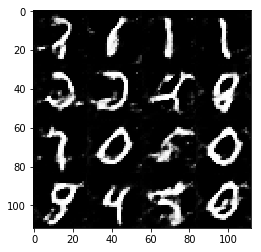

Epoch 0/2... Discriminator Loss: 1.3199... Generator Loss: 0.3818
Epoch 0/2... Discriminator Loss: 1.0862... Generator Loss: 1.6097
Epoch 0/2... Discriminator Loss: 0.7943... Generator Loss: 1.7464
Epoch 0/2... Discriminator Loss: 0.5869... Generator Loss: 1.5122
Epoch 0/2... Discriminator Loss: 2.1819... Generator Loss: 0.2119
Epoch 0/2... Discriminator Loss: 1.6319... Generator Loss: 0.3926
Epoch 0/2... Discriminator Loss: 2.3957... Generator Loss: 0.1405
Epoch 0/2... Discriminator Loss: 0.7895... Generator Loss: 0.7928
Epoch 0/2... Discriminator Loss: 1.4039... Generator Loss: 0.4366
Epoch 0/2... Discriminator Loss: 1.7957... Generator Loss: 0.3681
Epoch 0/2... Discriminator Loss: 1.0144... Generator Loss: 0.5866
Epoch 0/2... Discriminator Loss: 1.9703... Generator Loss: 0.1833
Epoch 0/2... Discriminator Loss: 2.2138... Generator Loss: 4.8627
Epoch 0/2... Discriminator Loss: 0.5821... Generator Loss: 1.1079
Epoch 0/2... Discriminator Loss: 1.0076... Generator Loss: 1.5835
Epoch 0/2.

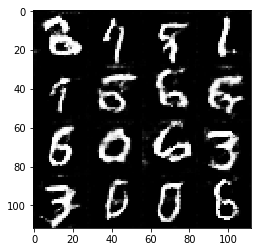

Epoch 0/2... Discriminator Loss: 0.6033... Generator Loss: 1.8687
Epoch 0/2... Discriminator Loss: 1.7727... Generator Loss: 0.2364
Epoch 0/2... Discriminator Loss: 1.8188... Generator Loss: 0.2279
Epoch 0/2... Discriminator Loss: 2.8259... Generator Loss: 0.0752
Epoch 0/2... Discriminator Loss: 1.0462... Generator Loss: 0.7660
Epoch 0/2... Discriminator Loss: 2.0025... Generator Loss: 0.2575
Epoch 0/2... Discriminator Loss: 1.6917... Generator Loss: 3.2289
Epoch 0/2... Discriminator Loss: 0.9808... Generator Loss: 1.6840
Epoch 0/2... Discriminator Loss: 1.0117... Generator Loss: 0.5688
Epoch 0/2... Discriminator Loss: 0.8535... Generator Loss: 0.8785
Epoch 0/2... Discriminator Loss: 1.5960... Generator Loss: 0.2905
Epoch 0/2... Discriminator Loss: 0.7756... Generator Loss: 1.1027
Epoch 0/2... Discriminator Loss: 1.3132... Generator Loss: 0.4677
Epoch 0/2... Discriminator Loss: 1.1594... Generator Loss: 0.5003
Epoch 0/2... Discriminator Loss: 1.0853... Generator Loss: 0.5474
Epoch 0/2.

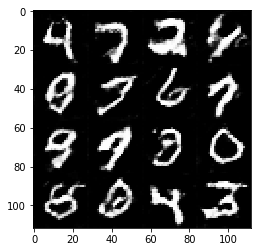

Epoch 0/2... Discriminator Loss: 1.2237... Generator Loss: 0.4291
Epoch 0/2... Discriminator Loss: 0.7445... Generator Loss: 1.6219
Epoch 0/2... Discriminator Loss: 3.0085... Generator Loss: 0.0969
Epoch 0/2... Discriminator Loss: 0.6541... Generator Loss: 1.7642
Epoch 0/2... Discriminator Loss: 0.6251... Generator Loss: 1.0412
Epoch 0/2... Discriminator Loss: 0.2958... Generator Loss: 2.1135
Epoch 0/2... Discriminator Loss: 1.0268... Generator Loss: 0.6069
Epoch 0/2... Discriminator Loss: 1.0812... Generator Loss: 1.2321
Epoch 0/2... Discriminator Loss: 0.4807... Generator Loss: 1.3984
Epoch 0/2... Discriminator Loss: 0.7972... Generator Loss: 1.7383
Epoch 0/2... Discriminator Loss: 1.4408... Generator Loss: 0.7098
Epoch 0/2... Discriminator Loss: 0.5416... Generator Loss: 1.3694
Epoch 0/2... Discriminator Loss: 1.2741... Generator Loss: 0.5003
Epoch 0/2... Discriminator Loss: 1.5196... Generator Loss: 0.4112
Epoch 0/2... Discriminator Loss: 0.5798... Generator Loss: 1.5154
Epoch 0/2.

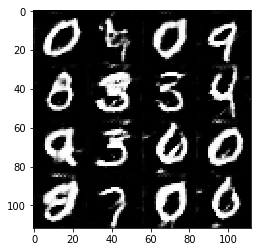

Epoch 0/2... Discriminator Loss: 1.2548... Generator Loss: 0.4291
Epoch 0/2... Discriminator Loss: 0.6280... Generator Loss: 1.5491
Epoch 0/2... Discriminator Loss: 1.2533... Generator Loss: 0.9027
Epoch 0/2... Discriminator Loss: 0.6859... Generator Loss: 1.0357
Epoch 0/2... Discriminator Loss: 2.4506... Generator Loss: 0.1177
Epoch 0/2... Discriminator Loss: 0.7549... Generator Loss: 1.2329
Epoch 0/2... Discriminator Loss: 0.6897... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 2.0907... Generator Loss: 0.2196
Epoch 1/2... Discriminator Loss: 1.8430... Generator Loss: 0.2532
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.9126... Generator Loss: 0.2877
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 2.0588
Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.4381
Epoch 1/2.

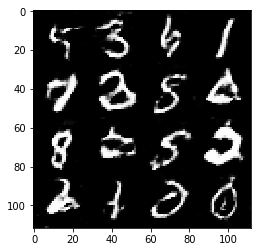

Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 0.5869
Epoch 1/2... Discriminator Loss: 1.8802... Generator Loss: 2.6616
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.2746
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 2.1759... Generator Loss: 0.1833
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 0.5165... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 1.7101... Generator Loss: 0.2867
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 3.7900... Generator Loss: 5.1503
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 1.1571
Epoch 1/2.

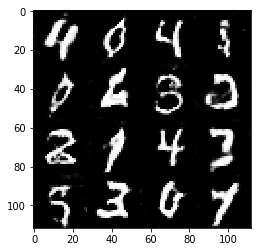

Epoch 1/2... Discriminator Loss: 1.6364... Generator Loss: 0.2689
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 0.7038... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.5955... Generator Loss: 0.2702
Epoch 1/2... Discriminator Loss: 2.2790... Generator Loss: 0.1527
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 4.4295
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.3813
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 3.5582
Epoch 1/2... Discriminator Loss: 2.3017... Generator Loss: 0.2038
Epoch 1/2... Discriminator Loss: 3.1791... Generator Loss: 0.0594
Epoch 1/2... Discriminator Loss: 2.3023... Generator Loss: 0.1392
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 0.6375... Generator Loss: 0.9733
Epoch 1/2.

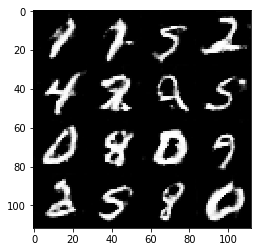

Epoch 1/2... Discriminator Loss: 2.0547... Generator Loss: 0.1723
Epoch 1/2... Discriminator Loss: 2.0090... Generator Loss: 0.1923
Epoch 1/2... Discriminator Loss: 0.5859... Generator Loss: 2.3302
Epoch 1/2... Discriminator Loss: 1.9875... Generator Loss: 0.1956
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.3575
Epoch 1/2... Discriminator Loss: 2.1712... Generator Loss: 0.1911
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 3.1521... Generator Loss: 0.0666
Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 1.5223
Epoch 1/2... Discriminator Loss: 0.8956... Generator Loss: 1.5374
Epoch 1/2... Discriminator Loss: 3.5986... Generator Loss: 0.0450
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 1.0091
Epoch 1/2.

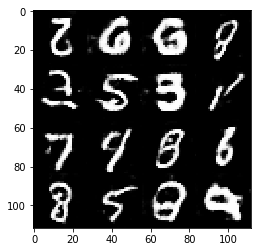

Epoch 1/2... Discriminator Loss: 0.2582... Generator Loss: 2.0045
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.8438... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 0.3897... Generator Loss: 2.0324
Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.4031
Epoch 1/2... Discriminator Loss: 4.0003... Generator Loss: 0.0298
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 3.0022
Epoch 1/2... Discriminator Loss: 2.4799... Generator Loss: 0.1317
Epoch 1/2... Discriminator Loss: 1.8050... Generator Loss: 0.2311
Epoch 1/2... Discriminator Loss: 2.8138... Generator Loss: 0.1094
Epoch 1/2... Discriminator Loss: 3.7910... Generator Loss: 0.0384
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 1.1030
Epoch 1/2... Discriminator Loss: 2.6774... Generator Loss: 0.0903
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 0.6182... Generator Loss: 1.0632
Epoch 1/2.

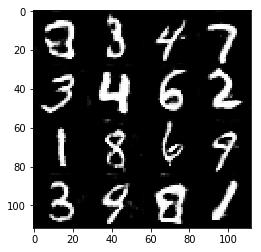

Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.4860
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 1.7562
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 2.8651... Generator Loss: 0.0987
Epoch 1/2... Discriminator Loss: 3.2723... Generator Loss: 0.0586
Epoch 1/2... Discriminator Loss: 2.8256... Generator Loss: 0.0903
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 2.0923... Generator Loss: 0.1806
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 2.0656... Generator Loss: 0.2265
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.2986
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 4.5990... Generator Loss: 0.0157
Epoch 1/2... Discriminator Loss: 2.8217... Generator Loss: 0.1448
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 0.5690
Epoch 1/2.

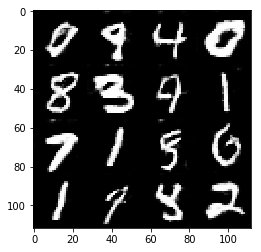

Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 1.3361
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.8682
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.7189... Generator Loss: 0.2814
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 2.8160
Epoch 1/2... Discriminator Loss: 2.6347... Generator Loss: 0.1227
Epoch 1/2... Discriminator Loss: 1.9454... Generator Loss: 0.1947
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 1.6612
Epoch 1/2... Discriminator Loss: 1.8424... Generator Loss: 0.2306
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.6927... Generator Loss: 0.2561
Epoch 1/2... Discriminator Loss: 1.4853... Generator Loss: 0.3453
Epoch 1/2.

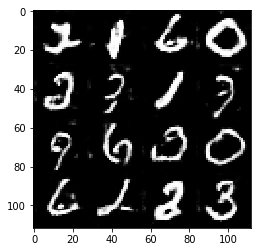

Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 3.1209
Epoch 1/2... Discriminator Loss: 2.3526... Generator Loss: 0.1738
Epoch 1/2... Discriminator Loss: 2.9157... Generator Loss: 0.0699
Epoch 1/2... Discriminator Loss: 1.6999... Generator Loss: 0.2458
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.1186
Epoch 1/2... Discriminator Loss: 3.2568... Generator Loss: 0.0632
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 0.5620
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.2757
Epoch 1/2... Discriminator Loss: 1.7324... Generator Loss: 0.2729
Epoch 1/2... Discriminator Loss: 2.4598... Generator Loss: 0.1678
Epoch 1/2... Discriminator Loss: 1.9716... Generator Loss: 0.1887
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 1.5653
Epoch 1/2.

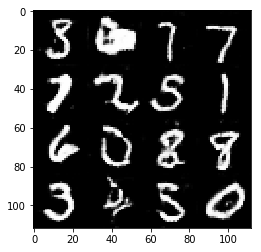

Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.4677
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.3407
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.5397
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 2.9820... Generator Loss: 0.0656
Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 1.2928
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 3.4799
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 0.2458... Generator Loss: 2.1909
Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 2.6591
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.0431
Epoch 1/2.

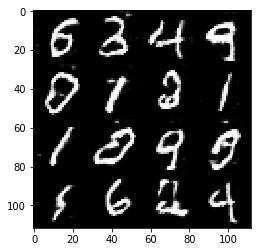

Epoch 1/2... Discriminator Loss: 0.4418... Generator Loss: 2.1077
Epoch 1/2... Discriminator Loss: 2.9126... Generator Loss: 0.1034
Epoch 1/2... Discriminator Loss: 3.5897... Generator Loss: 0.0362
Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 3.4235
Epoch 1/2... Discriminator Loss: 2.2044... Generator Loss: 0.1631
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.5373
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 2.4883
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.3968
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 2.5182... Generator Loss: 0.4393
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.4782
Epoch 1/2... Discriminator Loss: 1.6503... Generator Loss: 0.2887
Epoch 1/2... Discriminator Loss: 0.6657... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 0.6086


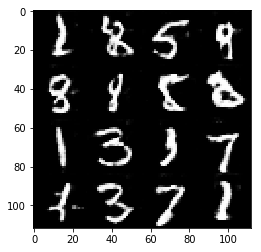

In [16]:
batch_size = 32
z_dim = 300
learning_rate = 0.00072
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.6874... Generator Loss: 1.0789
Epoch 0/1... Discriminator Loss: 2.9845... Generator Loss: 0.2382
Epoch 0/1... Discriminator Loss: 1.7683... Generator Loss: 0.6258
Epoch 0/1... Discriminator Loss: 0.5754... Generator Loss: 1.1689
Epoch 0/1... Discriminator Loss: 1.5042... Generator Loss: 1.2516
Epoch 0/1... Discriminator Loss: 1.6549... Generator Loss: 0.2627
Epoch 0/1... Discriminator Loss: 5.5239... Generator Loss: 0.0053
Epoch 0/1... Discriminator Loss: 0.9028... Generator Loss: 1.6273
Epoch 0/1... Discriminator Loss: 1.5945... Generator Loss: 1.7274
Epoch 0/1... Discriminator Loss: 1.4728... Generator Loss: 0.3937
Epoch 0/1... Discriminator Loss: 1.1922... Generator Loss: 0.8709
Epoch 0/1... Discriminator Loss: 1.5541... Generator Loss: 0.4675
Epoch 0/1... Discriminator Loss: 1.1319... Generator Loss: 1.1473
Epoch 0/1... Discriminator Loss: 0.5567... Generator Loss: 1.0404
Epoch 0/1... Discriminator Loss: 2.0892... Generator Loss: 2.4130
Epoch 0/1.

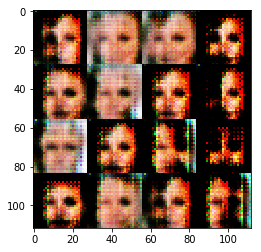

Epoch 0/1... Discriminator Loss: 1.3913... Generator Loss: 0.5655
Epoch 0/1... Discriminator Loss: 1.8724... Generator Loss: 0.4207
Epoch 0/1... Discriminator Loss: 1.1207... Generator Loss: 0.8421
Epoch 0/1... Discriminator Loss: 1.3191... Generator Loss: 0.4190
Epoch 0/1... Discriminator Loss: 0.9907... Generator Loss: 0.9464
Epoch 0/1... Discriminator Loss: 0.8844... Generator Loss: 1.2029
Epoch 0/1... Discriminator Loss: 1.6982... Generator Loss: 0.4659
Epoch 0/1... Discriminator Loss: 1.1997... Generator Loss: 0.8918
Epoch 0/1... Discriminator Loss: 1.2247... Generator Loss: 0.6851
Epoch 0/1... Discriminator Loss: 1.3209... Generator Loss: 0.7221
Epoch 0/1... Discriminator Loss: 1.2089... Generator Loss: 0.7113
Epoch 0/1... Discriminator Loss: 1.3227... Generator Loss: 0.3905
Epoch 0/1... Discriminator Loss: 1.5488... Generator Loss: 1.3564
Epoch 0/1... Discriminator Loss: 0.7692... Generator Loss: 1.0388
Epoch 0/1... Discriminator Loss: 1.1662... Generator Loss: 0.7195
Epoch 0/1.

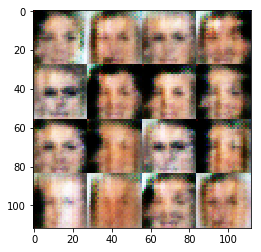

Epoch 0/1... Discriminator Loss: 2.0226... Generator Loss: 0.1805
Epoch 0/1... Discriminator Loss: 1.1726... Generator Loss: 0.6832
Epoch 0/1... Discriminator Loss: 1.2239... Generator Loss: 1.2438
Epoch 0/1... Discriminator Loss: 0.6814... Generator Loss: 0.9647
Epoch 0/1... Discriminator Loss: 1.2541... Generator Loss: 1.4923
Epoch 0/1... Discriminator Loss: 1.0739... Generator Loss: 0.6671
Epoch 0/1... Discriminator Loss: 2.3570... Generator Loss: 0.1142
Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 0.8567
Epoch 0/1... Discriminator Loss: 1.4477... Generator Loss: 0.4914
Epoch 0/1... Discriminator Loss: 1.0475... Generator Loss: 1.0009
Epoch 0/1... Discriminator Loss: 0.8975... Generator Loss: 1.0221
Epoch 0/1... Discriminator Loss: 1.2102... Generator Loss: 0.8411
Epoch 0/1... Discriminator Loss: 0.9189... Generator Loss: 0.9382
Epoch 0/1... Discriminator Loss: 1.6658... Generator Loss: 0.3464
Epoch 0/1... Discriminator Loss: 1.2491... Generator Loss: 0.5837
Epoch 0/1.

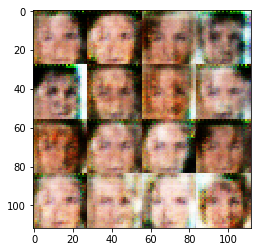

Epoch 0/1... Discriminator Loss: 1.7973... Generator Loss: 0.2691
Epoch 0/1... Discriminator Loss: 1.3485... Generator Loss: 0.4444
Epoch 0/1... Discriminator Loss: 2.2987... Generator Loss: 2.5914
Epoch 0/1... Discriminator Loss: 1.0572... Generator Loss: 1.2156
Epoch 0/1... Discriminator Loss: 1.9786... Generator Loss: 0.2214
Epoch 0/1... Discriminator Loss: 1.4694... Generator Loss: 0.3559
Epoch 0/1... Discriminator Loss: 1.5035... Generator Loss: 0.4712
Epoch 0/1... Discriminator Loss: 1.1607... Generator Loss: 0.6026
Epoch 0/1... Discriminator Loss: 1.5651... Generator Loss: 2.1101
Epoch 0/1... Discriminator Loss: 0.9178... Generator Loss: 1.2089
Epoch 0/1... Discriminator Loss: 3.0657... Generator Loss: 0.0773
Epoch 0/1... Discriminator Loss: 1.3632... Generator Loss: 0.8904
Epoch 0/1... Discriminator Loss: 1.2794... Generator Loss: 0.6981
Epoch 0/1... Discriminator Loss: 1.3144... Generator Loss: 0.6809
Epoch 0/1... Discriminator Loss: 1.3265... Generator Loss: 0.5084
Epoch 0/1.

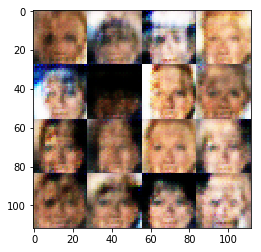

Epoch 0/1... Discriminator Loss: 1.7307... Generator Loss: 0.3232
Epoch 0/1... Discriminator Loss: 1.3491... Generator Loss: 0.6592
Epoch 0/1... Discriminator Loss: 1.2935... Generator Loss: 0.5288
Epoch 0/1... Discriminator Loss: 1.5366... Generator Loss: 0.2943
Epoch 0/1... Discriminator Loss: 1.1349... Generator Loss: 1.0543
Epoch 0/1... Discriminator Loss: 1.1930... Generator Loss: 0.6780
Epoch 0/1... Discriminator Loss: 1.2511... Generator Loss: 0.9343
Epoch 0/1... Discriminator Loss: 1.1210... Generator Loss: 0.9192
Epoch 0/1... Discriminator Loss: 1.1397... Generator Loss: 0.5881
Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 0.8733
Epoch 0/1... Discriminator Loss: 1.3394... Generator Loss: 0.5130
Epoch 0/1... Discriminator Loss: 1.9678... Generator Loss: 0.2249
Epoch 0/1... Discriminator Loss: 1.2350... Generator Loss: 0.7375
Epoch 0/1... Discriminator Loss: 1.6029... Generator Loss: 0.4104
Epoch 0/1... Discriminator Loss: 1.1212... Generator Loss: 1.0338
Epoch 0/1.

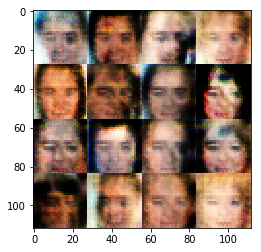

Epoch 0/1... Discriminator Loss: 1.1474... Generator Loss: 0.6878
Epoch 0/1... Discriminator Loss: 1.4531... Generator Loss: 0.4329
Epoch 0/1... Discriminator Loss: 1.6272... Generator Loss: 0.4789
Epoch 0/1... Discriminator Loss: 1.6795... Generator Loss: 0.2840
Epoch 0/1... Discriminator Loss: 1.6663... Generator Loss: 0.3366
Epoch 0/1... Discriminator Loss: 1.2139... Generator Loss: 0.6122
Epoch 0/1... Discriminator Loss: 1.2506... Generator Loss: 0.5205
Epoch 0/1... Discriminator Loss: 1.4715... Generator Loss: 0.6417
Epoch 0/1... Discriminator Loss: 1.8660... Generator Loss: 0.2184
Epoch 0/1... Discriminator Loss: 1.4602... Generator Loss: 0.7661
Epoch 0/1... Discriminator Loss: 1.4580... Generator Loss: 0.6542
Epoch 0/1... Discriminator Loss: 1.0981... Generator Loss: 0.7323
Epoch 0/1... Discriminator Loss: 1.6002... Generator Loss: 0.3013
Epoch 0/1... Discriminator Loss: 1.1205... Generator Loss: 1.1624
Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.7097
Epoch 0/1.

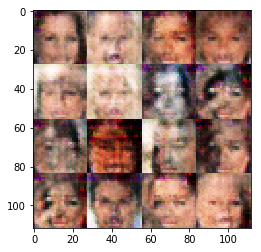

Epoch 0/1... Discriminator Loss: 1.4715... Generator Loss: 0.3999
Epoch 0/1... Discriminator Loss: 1.4060... Generator Loss: 0.4450
Epoch 0/1... Discriminator Loss: 1.2782... Generator Loss: 1.1391
Epoch 0/1... Discriminator Loss: 1.4668... Generator Loss: 1.4824
Epoch 0/1... Discriminator Loss: 1.4489... Generator Loss: 0.5664
Epoch 0/1... Discriminator Loss: 1.2909... Generator Loss: 0.5064
Epoch 0/1... Discriminator Loss: 1.2925... Generator Loss: 0.6377
Epoch 0/1... Discriminator Loss: 1.4626... Generator Loss: 0.4146
Epoch 0/1... Discriminator Loss: 2.2958... Generator Loss: 0.1336
Epoch 0/1... Discriminator Loss: 1.2470... Generator Loss: 0.7775
Epoch 0/1... Discriminator Loss: 1.2668... Generator Loss: 0.7266
Epoch 0/1... Discriminator Loss: 1.4523... Generator Loss: 0.9583
Epoch 0/1... Discriminator Loss: 1.4252... Generator Loss: 0.8747
Epoch 0/1... Discriminator Loss: 1.6116... Generator Loss: 0.2965
Epoch 0/1... Discriminator Loss: 1.3003... Generator Loss: 0.5291
Epoch 0/1.

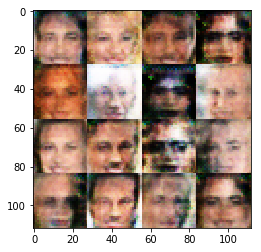

Epoch 0/1... Discriminator Loss: 1.5365... Generator Loss: 0.3891
Epoch 0/1... Discriminator Loss: 1.6712... Generator Loss: 0.2917
Epoch 0/1... Discriminator Loss: 1.2821... Generator Loss: 0.5091
Epoch 0/1... Discriminator Loss: 1.0625... Generator Loss: 0.8093
Epoch 0/1... Discriminator Loss: 1.3287... Generator Loss: 0.6751
Epoch 0/1... Discriminator Loss: 1.4824... Generator Loss: 0.5653
Epoch 0/1... Discriminator Loss: 1.1862... Generator Loss: 1.0419
Epoch 0/1... Discriminator Loss: 1.1913... Generator Loss: 0.7590
Epoch 0/1... Discriminator Loss: 1.3757... Generator Loss: 0.5412
Epoch 0/1... Discriminator Loss: 1.7487... Generator Loss: 0.2504
Epoch 0/1... Discriminator Loss: 1.3694... Generator Loss: 0.5496
Epoch 0/1... Discriminator Loss: 1.3716... Generator Loss: 0.5318
Epoch 0/1... Discriminator Loss: 1.7214... Generator Loss: 0.2802
Epoch 0/1... Discriminator Loss: 1.3919... Generator Loss: 0.4997
Epoch 0/1... Discriminator Loss: 1.4198... Generator Loss: 0.4140
Epoch 0/1.

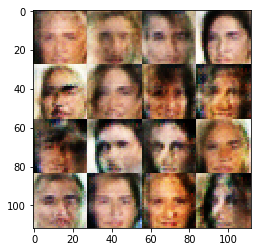

Epoch 0/1... Discriminator Loss: 1.8184... Generator Loss: 0.2269
Epoch 0/1... Discriminator Loss: 1.2453... Generator Loss: 0.6122
Epoch 0/1... Discriminator Loss: 1.5557... Generator Loss: 0.3098
Epoch 0/1... Discriminator Loss: 1.6066... Generator Loss: 0.7698
Epoch 0/1... Discriminator Loss: 1.5030... Generator Loss: 0.3707
Epoch 0/1... Discriminator Loss: 1.5197... Generator Loss: 0.7856
Epoch 0/1... Discriminator Loss: 1.6224... Generator Loss: 0.3214
Epoch 0/1... Discriminator Loss: 1.3397... Generator Loss: 0.5239
Epoch 0/1... Discriminator Loss: 1.2569... Generator Loss: 0.6018
Epoch 0/1... Discriminator Loss: 1.3446... Generator Loss: 0.7356
Epoch 0/1... Discriminator Loss: 1.4252... Generator Loss: 0.4429
Epoch 0/1... Discriminator Loss: 2.0471... Generator Loss: 0.1725
Epoch 0/1... Discriminator Loss: 1.7836... Generator Loss: 0.2487
Epoch 0/1... Discriminator Loss: 1.2796... Generator Loss: 0.8556
Epoch 0/1... Discriminator Loss: 1.4199... Generator Loss: 0.5317
Epoch 0/1.

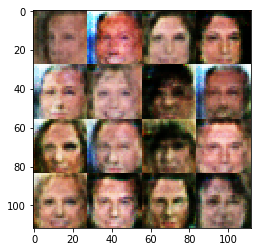

Epoch 0/1... Discriminator Loss: 1.5636... Generator Loss: 0.3973
Epoch 0/1... Discriminator Loss: 1.6699... Generator Loss: 0.2738
Epoch 0/1... Discriminator Loss: 1.6158... Generator Loss: 0.3641
Epoch 0/1... Discriminator Loss: 1.3300... Generator Loss: 0.4482
Epoch 0/1... Discriminator Loss: 1.2189... Generator Loss: 0.5835
Epoch 0/1... Discriminator Loss: 1.4241... Generator Loss: 0.9916
Epoch 0/1... Discriminator Loss: 1.3513... Generator Loss: 0.7375
Epoch 0/1... Discriminator Loss: 2.1822... Generator Loss: 0.1565
Epoch 0/1... Discriminator Loss: 1.4377... Generator Loss: 0.5427
Epoch 0/1... Discriminator Loss: 1.5315... Generator Loss: 0.9321
Epoch 0/1... Discriminator Loss: 1.4175... Generator Loss: 0.5483
Epoch 0/1... Discriminator Loss: 1.3360... Generator Loss: 0.7076
Epoch 0/1... Discriminator Loss: 1.5373... Generator Loss: 0.3727
Epoch 0/1... Discriminator Loss: 1.3506... Generator Loss: 1.1760
Epoch 0/1... Discriminator Loss: 1.2872... Generator Loss: 1.0906
Epoch 0/1.

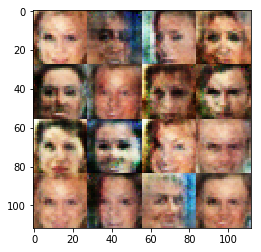

Epoch 0/1... Discriminator Loss: 1.6121... Generator Loss: 0.2947
Epoch 0/1... Discriminator Loss: 1.3456... Generator Loss: 0.6297
Epoch 0/1... Discriminator Loss: 1.2793... Generator Loss: 0.7756
Epoch 0/1... Discriminator Loss: 1.4393... Generator Loss: 0.5182
Epoch 0/1... Discriminator Loss: 1.7120... Generator Loss: 1.2818
Epoch 0/1... Discriminator Loss: 1.3273... Generator Loss: 0.6284
Epoch 0/1... Discriminator Loss: 1.3460... Generator Loss: 0.5780
Epoch 0/1... Discriminator Loss: 1.5060... Generator Loss: 0.7168
Epoch 0/1... Discriminator Loss: 1.3728... Generator Loss: 1.3764
Epoch 0/1... Discriminator Loss: 1.3686... Generator Loss: 0.4862
Epoch 0/1... Discriminator Loss: 1.6817... Generator Loss: 0.2991
Epoch 0/1... Discriminator Loss: 1.5097... Generator Loss: 0.3802
Epoch 0/1... Discriminator Loss: 1.3348... Generator Loss: 0.6304
Epoch 0/1... Discriminator Loss: 1.3656... Generator Loss: 0.9811
Epoch 0/1... Discriminator Loss: 1.6731... Generator Loss: 0.3060
Epoch 0/1.

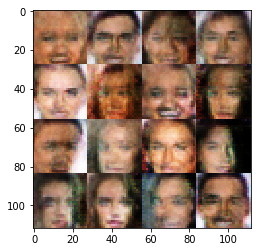

Epoch 0/1... Discriminator Loss: 1.6299... Generator Loss: 0.3866
Epoch 0/1... Discriminator Loss: 1.7855... Generator Loss: 0.2354
Epoch 0/1... Discriminator Loss: 1.6736... Generator Loss: 0.3725
Epoch 0/1... Discriminator Loss: 1.8710... Generator Loss: 0.2141
Epoch 0/1... Discriminator Loss: 1.2999... Generator Loss: 0.5526
Epoch 0/1... Discriminator Loss: 1.8515... Generator Loss: 0.2280
Epoch 0/1... Discriminator Loss: 2.2547... Generator Loss: 0.1477
Epoch 0/1... Discriminator Loss: 1.7029... Generator Loss: 0.2849
Epoch 0/1... Discriminator Loss: 1.7733... Generator Loss: 0.2540
Epoch 0/1... Discriminator Loss: 1.6763... Generator Loss: 0.3189
Epoch 0/1... Discriminator Loss: 1.7290... Generator Loss: 0.2783
Epoch 0/1... Discriminator Loss: 2.2867... Generator Loss: 0.1436
Epoch 0/1... Discriminator Loss: 1.3101... Generator Loss: 0.9570
Epoch 0/1... Discriminator Loss: 1.4616... Generator Loss: 0.8113
Epoch 0/1... Discriminator Loss: 1.6975... Generator Loss: 0.3184
Epoch 0/1.

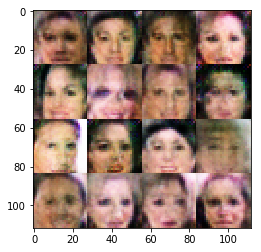

Epoch 0/1... Discriminator Loss: 1.7168... Generator Loss: 0.2924
Epoch 0/1... Discriminator Loss: 1.6828... Generator Loss: 0.2665
Epoch 0/1... Discriminator Loss: 1.5020... Generator Loss: 0.5099
Epoch 0/1... Discriminator Loss: 1.4826... Generator Loss: 0.5979
Epoch 0/1... Discriminator Loss: 1.5968... Generator Loss: 1.0798
Epoch 0/1... Discriminator Loss: 1.7870... Generator Loss: 0.2567
Epoch 0/1... Discriminator Loss: 1.2150... Generator Loss: 0.5648
Epoch 0/1... Discriminator Loss: 1.6996... Generator Loss: 0.2929
Epoch 0/1... Discriminator Loss: 1.2486... Generator Loss: 0.6402
Epoch 0/1... Discriminator Loss: 1.1481... Generator Loss: 1.0699
Epoch 0/1... Discriminator Loss: 1.4587... Generator Loss: 0.4726
Epoch 0/1... Discriminator Loss: 1.3966... Generator Loss: 1.0495
Epoch 0/1... Discriminator Loss: 1.4075... Generator Loss: 0.5917
Epoch 0/1... Discriminator Loss: 1.2961... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 1.2987... Generator Loss: 1.0413
Epoch 0/1.

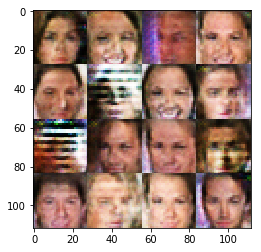

Epoch 0/1... Discriminator Loss: 1.2800... Generator Loss: 0.7473
Epoch 0/1... Discriminator Loss: 1.4629... Generator Loss: 0.4397
Epoch 0/1... Discriminator Loss: 1.7456... Generator Loss: 0.2593
Epoch 0/1... Discriminator Loss: 1.5029... Generator Loss: 0.3395
Epoch 0/1... Discriminator Loss: 1.2643... Generator Loss: 0.7616
Epoch 0/1... Discriminator Loss: 1.5933... Generator Loss: 1.7360
Epoch 0/1... Discriminator Loss: 1.5591... Generator Loss: 0.3611
Epoch 0/1... Discriminator Loss: 1.3787... Generator Loss: 0.4929
Epoch 0/1... Discriminator Loss: 2.1095... Generator Loss: 0.1543
Epoch 0/1... Discriminator Loss: 1.7150... Generator Loss: 0.2696
Epoch 0/1... Discriminator Loss: 1.6003... Generator Loss: 0.3165
Epoch 0/1... Discriminator Loss: 1.4314... Generator Loss: 0.7040
Epoch 0/1... Discriminator Loss: 1.6615... Generator Loss: 0.2868
Epoch 0/1... Discriminator Loss: 1.5194... Generator Loss: 0.7948
Epoch 0/1... Discriminator Loss: 1.5589... Generator Loss: 0.8804
Epoch 0/1.

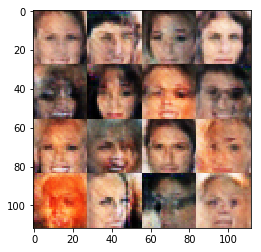

Epoch 0/1... Discriminator Loss: 1.8418... Generator Loss: 0.2790
Epoch 0/1... Discriminator Loss: 1.9647... Generator Loss: 0.2007
Epoch 0/1... Discriminator Loss: 1.4620... Generator Loss: 0.4544
Epoch 0/1... Discriminator Loss: 1.5897... Generator Loss: 0.3725
Epoch 0/1... Discriminator Loss: 1.8922... Generator Loss: 0.2575
Epoch 0/1... Discriminator Loss: 1.6527... Generator Loss: 0.3455
Epoch 0/1... Discriminator Loss: 1.8622... Generator Loss: 0.2192
Epoch 0/1... Discriminator Loss: 1.4218... Generator Loss: 1.5155
Epoch 0/1... Discriminator Loss: 1.1457... Generator Loss: 0.9072
Epoch 0/1... Discriminator Loss: 1.9716... Generator Loss: 0.2035
Epoch 0/1... Discriminator Loss: 2.8419... Generator Loss: 0.0752
Epoch 0/1... Discriminator Loss: 1.4150... Generator Loss: 0.4488
Epoch 0/1... Discriminator Loss: 1.6673... Generator Loss: 0.3172
Epoch 0/1... Discriminator Loss: 3.2352... Generator Loss: 0.0480
Epoch 0/1... Discriminator Loss: 1.4135... Generator Loss: 0.4931
Epoch 0/1.

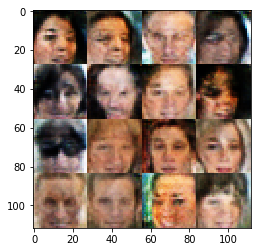

Epoch 0/1... Discriminator Loss: 1.4670... Generator Loss: 0.4699
Epoch 0/1... Discriminator Loss: 1.0692... Generator Loss: 0.7776
Epoch 0/1... Discriminator Loss: 1.6140... Generator Loss: 0.3092
Epoch 0/1... Discriminator Loss: 1.2114... Generator Loss: 0.6982
Epoch 0/1... Discriminator Loss: 1.1504... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.3740... Generator Loss: 0.5939
Epoch 0/1... Discriminator Loss: 1.4334... Generator Loss: 0.4006
Epoch 0/1... Discriminator Loss: 1.3724... Generator Loss: 0.6755
Epoch 0/1... Discriminator Loss: 1.2862... Generator Loss: 0.9168
Epoch 0/1... Discriminator Loss: 1.3265... Generator Loss: 1.2507
Epoch 0/1... Discriminator Loss: 1.3361... Generator Loss: 0.5916
Epoch 0/1... Discriminator Loss: 1.2880... Generator Loss: 0.8535
Epoch 0/1... Discriminator Loss: 1.8184... Generator Loss: 1.7273
Epoch 0/1... Discriminator Loss: 1.3378... Generator Loss: 0.5337
Epoch 0/1... Discriminator Loss: 2.1839... Generator Loss: 0.1469
Epoch 0/1.

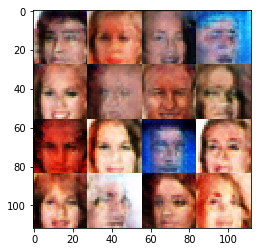

Epoch 0/1... Discriminator Loss: 1.8149... Generator Loss: 0.2790
Epoch 0/1... Discriminator Loss: 1.8567... Generator Loss: 0.2140
Epoch 0/1... Discriminator Loss: 1.5896... Generator Loss: 0.3759
Epoch 0/1... Discriminator Loss: 1.7438... Generator Loss: 0.2825
Epoch 0/1... Discriminator Loss: 1.8698... Generator Loss: 0.2218
Epoch 0/1... Discriminator Loss: 1.6210... Generator Loss: 0.2932
Epoch 0/1... Discriminator Loss: 1.8892... Generator Loss: 0.2586
Epoch 0/1... Discriminator Loss: 1.4278... Generator Loss: 0.4258
Epoch 0/1... Discriminator Loss: 1.5807... Generator Loss: 0.5834
Epoch 0/1... Discriminator Loss: 1.9178... Generator Loss: 0.2059
Epoch 0/1... Discriminator Loss: 1.4770... Generator Loss: 0.5794
Epoch 0/1... Discriminator Loss: 1.7242... Generator Loss: 0.2450
Epoch 0/1... Discriminator Loss: 1.5000... Generator Loss: 0.3662
Epoch 0/1... Discriminator Loss: 1.4746... Generator Loss: 0.5397
Epoch 0/1... Discriminator Loss: 1.6436... Generator Loss: 0.3069
Epoch 0/1.

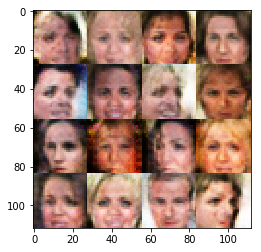

Epoch 0/1... Discriminator Loss: 1.0784... Generator Loss: 0.9805
Epoch 0/1... Discriminator Loss: 1.3831... Generator Loss: 0.6437
Epoch 0/1... Discriminator Loss: 1.8348... Generator Loss: 0.2635
Epoch 0/1... Discriminator Loss: 1.4081... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.7970
Epoch 0/1... Discriminator Loss: 1.5947... Generator Loss: 0.3120
Epoch 0/1... Discriminator Loss: 1.6625... Generator Loss: 0.4328
Epoch 0/1... Discriminator Loss: 1.2323... Generator Loss: 0.7172
Epoch 0/1... Discriminator Loss: 1.2625... Generator Loss: 0.8556
Epoch 0/1... Discriminator Loss: 1.0959... Generator Loss: 0.9913
Epoch 0/1... Discriminator Loss: 1.7062... Generator Loss: 0.2751
Epoch 0/1... Discriminator Loss: 2.2964... Generator Loss: 0.1372
Epoch 0/1... Discriminator Loss: 1.4643... Generator Loss: 0.5607
Epoch 0/1... Discriminator Loss: 1.7498... Generator Loss: 0.3460
Epoch 0/1... Discriminator Loss: 1.2817... Generator Loss: 0.5302
Epoch 0/1.

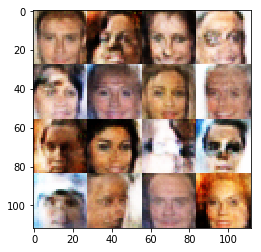

Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.5628
Epoch 0/1... Discriminator Loss: 1.5334... Generator Loss: 0.3905
Epoch 0/1... Discriminator Loss: 1.6885... Generator Loss: 0.2677
Epoch 0/1... Discriminator Loss: 1.2607... Generator Loss: 0.9725
Epoch 0/1... Discriminator Loss: 1.2078... Generator Loss: 0.6407
Epoch 0/1... Discriminator Loss: 1.6728... Generator Loss: 0.4526
Epoch 0/1... Discriminator Loss: 1.6034... Generator Loss: 0.3287
Epoch 0/1... Discriminator Loss: 2.2301... Generator Loss: 0.1462
Epoch 0/1... Discriminator Loss: 1.8781... Generator Loss: 0.2348
Epoch 0/1... Discriminator Loss: 1.8539... Generator Loss: 0.4658
Epoch 0/1... Discriminator Loss: 1.5962... Generator Loss: 0.3159
Epoch 0/1... Discriminator Loss: 1.2259... Generator Loss: 1.0611
Epoch 0/1... Discriminator Loss: 1.3896... Generator Loss: 0.5848
Epoch 0/1... Discriminator Loss: 2.1301... Generator Loss: 0.1625
Epoch 0/1... Discriminator Loss: 1.6028... Generator Loss: 0.3438
Epoch 0/1.

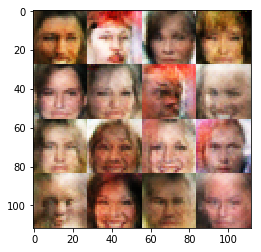

Epoch 0/1... Discriminator Loss: 1.3684... Generator Loss: 0.4657
Epoch 0/1... Discriminator Loss: 1.4330... Generator Loss: 0.5232
Epoch 0/1... Discriminator Loss: 1.5021... Generator Loss: 0.4602
Epoch 0/1... Discriminator Loss: 1.4695... Generator Loss: 0.8928
Epoch 0/1... Discriminator Loss: 1.7145... Generator Loss: 0.3963
Epoch 0/1... Discriminator Loss: 1.7636... Generator Loss: 0.2725
Epoch 0/1... Discriminator Loss: 1.8315... Generator Loss: 0.2480
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 1.6665
Epoch 0/1... Discriminator Loss: 1.2509... Generator Loss: 0.7100
Epoch 0/1... Discriminator Loss: 1.4757... Generator Loss: 0.3950
Epoch 0/1... Discriminator Loss: 1.3920... Generator Loss: 0.5738
Epoch 0/1... Discriminator Loss: 1.5925... Generator Loss: 0.3215
Epoch 0/1... Discriminator Loss: 1.2549... Generator Loss: 0.8770
Epoch 0/1... Discriminator Loss: 1.2084... Generator Loss: 0.7810
Epoch 0/1... Discriminator Loss: 1.9156... Generator Loss: 0.2155
Epoch 0/1.

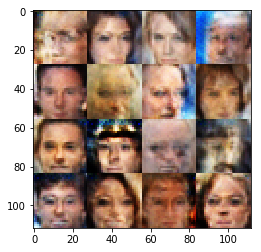

Epoch 0/1... Discriminator Loss: 1.4884... Generator Loss: 0.5214
Epoch 0/1... Discriminator Loss: 1.5083... Generator Loss: 0.5335
Epoch 0/1... Discriminator Loss: 1.6271... Generator Loss: 0.4153
Epoch 0/1... Discriminator Loss: 1.9079... Generator Loss: 0.2212
Epoch 0/1... Discriminator Loss: 2.0666... Generator Loss: 0.1854
Epoch 0/1... Discriminator Loss: 1.7178... Generator Loss: 0.4051
Epoch 0/1... Discriminator Loss: 1.2028... Generator Loss: 0.7640
Epoch 0/1... Discriminator Loss: 1.1279... Generator Loss: 0.6775
Epoch 0/1... Discriminator Loss: 1.4568... Generator Loss: 0.7962
Epoch 0/1... Discriminator Loss: 0.9922... Generator Loss: 1.0055
Epoch 0/1... Discriminator Loss: 2.0378... Generator Loss: 0.2317
Epoch 0/1... Discriminator Loss: 2.3054... Generator Loss: 0.1317
Epoch 0/1... Discriminator Loss: 1.4497... Generator Loss: 0.3968
Epoch 0/1... Discriminator Loss: 2.0018... Generator Loss: 0.1893
Epoch 0/1... Discriminator Loss: 1.7788... Generator Loss: 0.2833
Epoch 0/1.

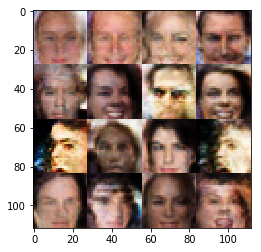

Epoch 0/1... Discriminator Loss: 2.2077... Generator Loss: 0.1473
Epoch 0/1... Discriminator Loss: 1.5943... Generator Loss: 0.3524
Epoch 0/1... Discriminator Loss: 2.4871... Generator Loss: 0.1176
Epoch 0/1... Discriminator Loss: 1.9567... Generator Loss: 0.3336
Epoch 0/1... Discriminator Loss: 1.7957... Generator Loss: 0.2479
Epoch 0/1... Discriminator Loss: 1.9982... Generator Loss: 0.1746
Epoch 0/1... Discriminator Loss: 1.3892... Generator Loss: 0.7251
Epoch 0/1... Discriminator Loss: 1.8901... Generator Loss: 0.2275
Epoch 0/1... Discriminator Loss: 1.4216... Generator Loss: 0.4299
Epoch 0/1... Discriminator Loss: 1.7489... Generator Loss: 0.3062
Epoch 0/1... Discriminator Loss: 1.9823... Generator Loss: 0.2121
Epoch 0/1... Discriminator Loss: 1.8528... Generator Loss: 0.2258
Epoch 0/1... Discriminator Loss: 1.2115... Generator Loss: 0.6243
Epoch 0/1... Discriminator Loss: 1.3297... Generator Loss: 0.6119
Epoch 0/1... Discriminator Loss: 1.4039... Generator Loss: 1.4991
Epoch 0/1.

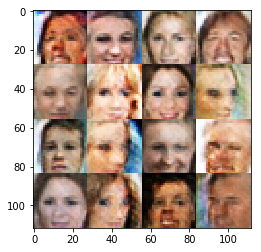

Epoch 0/1... Discriminator Loss: 1.7743... Generator Loss: 0.2477
Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 0.4927
Epoch 0/1... Discriminator Loss: 1.4206... Generator Loss: 0.6279
Epoch 0/1... Discriminator Loss: 1.1837... Generator Loss: 0.5907
Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.6554
Epoch 0/1... Discriminator Loss: 1.5029... Generator Loss: 0.4427
Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 0.4670
Epoch 0/1... Discriminator Loss: 1.4663... Generator Loss: 0.4020
Epoch 0/1... Discriminator Loss: 1.3905... Generator Loss: 1.1912
Epoch 0/1... Discriminator Loss: 1.3100... Generator Loss: 0.8493
Epoch 0/1... Discriminator Loss: 1.4410... Generator Loss: 0.4520
Epoch 0/1... Discriminator Loss: 1.7607... Generator Loss: 0.2603
Epoch 0/1... Discriminator Loss: 1.4039... Generator Loss: 0.4082
Epoch 0/1... Discriminator Loss: 1.2545... Generator Loss: 0.7012
Epoch 0/1... Discriminator Loss: 1.9080... Generator Loss: 0.1909
Epoch 0/1.

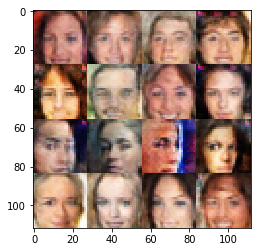

Epoch 0/1... Discriminator Loss: 1.8806... Generator Loss: 0.2289
Epoch 0/1... Discriminator Loss: 1.5653... Generator Loss: 0.4370
Epoch 0/1... Discriminator Loss: 1.8086... Generator Loss: 0.2522
Epoch 0/1... Discriminator Loss: 1.3671... Generator Loss: 0.3859
Epoch 0/1... Discriminator Loss: 1.2766... Generator Loss: 0.5462
Epoch 0/1... Discriminator Loss: 1.4481... Generator Loss: 0.5315
Epoch 0/1... Discriminator Loss: 1.1750... Generator Loss: 0.8066
Epoch 0/1... Discriminator Loss: 2.1753... Generator Loss: 0.1555
Epoch 0/1... Discriminator Loss: 1.5715... Generator Loss: 0.4467
Epoch 0/1... Discriminator Loss: 2.0499... Generator Loss: 0.1883
Epoch 0/1... Discriminator Loss: 1.6663... Generator Loss: 0.3139
Epoch 0/1... Discriminator Loss: 1.6167... Generator Loss: 0.5175
Epoch 0/1... Discriminator Loss: 1.3523... Generator Loss: 1.0432
Epoch 0/1... Discriminator Loss: 1.3722... Generator Loss: 0.7051
Epoch 0/1... Discriminator Loss: 1.4310... Generator Loss: 0.4510
Epoch 0/1.

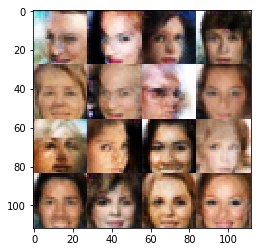

Epoch 0/1... Discriminator Loss: 1.7701... Generator Loss: 0.3366
Epoch 0/1... Discriminator Loss: 1.7963... Generator Loss: 0.2207
Epoch 0/1... Discriminator Loss: 1.2669... Generator Loss: 0.4997
Epoch 0/1... Discriminator Loss: 1.6643... Generator Loss: 0.3459
Epoch 0/1... Discriminator Loss: 1.4486... Generator Loss: 0.4452
Epoch 0/1... Discriminator Loss: 1.4762... Generator Loss: 0.4755
Epoch 0/1... Discriminator Loss: 1.4911... Generator Loss: 0.4686
Epoch 0/1... Discriminator Loss: 1.4575... Generator Loss: 0.3553
Epoch 0/1... Discriminator Loss: 1.7877... Generator Loss: 0.4387
Epoch 0/1... Discriminator Loss: 1.7207... Generator Loss: 0.2620
Epoch 0/1... Discriminator Loss: 1.7466... Generator Loss: 0.2579
Epoch 0/1... Discriminator Loss: 1.7917... Generator Loss: 0.2570
Epoch 0/1... Discriminator Loss: 1.7402... Generator Loss: 0.2792
Epoch 0/1... Discriminator Loss: 1.5548... Generator Loss: 0.3904
Epoch 0/1... Discriminator Loss: 1.7304... Generator Loss: 0.3058
Epoch 0/1.

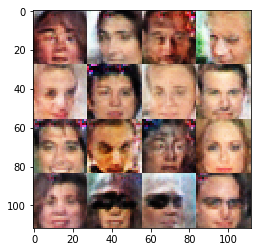

Epoch 0/1... Discriminator Loss: 2.0487... Generator Loss: 0.1913
Epoch 0/1... Discriminator Loss: 1.8949... Generator Loss: 0.2138
Epoch 0/1... Discriminator Loss: 1.7409... Generator Loss: 0.2349
Epoch 0/1... Discriminator Loss: 1.8210... Generator Loss: 0.2397
Epoch 0/1... Discriminator Loss: 1.5783... Generator Loss: 0.3239
Epoch 0/1... Discriminator Loss: 1.3250... Generator Loss: 0.5461
Epoch 0/1... Discriminator Loss: 1.6011... Generator Loss: 0.2950
Epoch 0/1... Discriminator Loss: 1.7074... Generator Loss: 0.2512
Epoch 0/1... Discriminator Loss: 2.0664... Generator Loss: 0.1895
Epoch 0/1... Discriminator Loss: 1.8127... Generator Loss: 0.2615
Epoch 0/1... Discriminator Loss: 2.0335... Generator Loss: 0.1893
Epoch 0/1... Discriminator Loss: 1.5779... Generator Loss: 0.3213
Epoch 0/1... Discriminator Loss: 1.9296... Generator Loss: 0.2090
Epoch 0/1... Discriminator Loss: 1.2337... Generator Loss: 0.7957
Epoch 0/1... Discriminator Loss: 1.3272... Generator Loss: 0.5452
Epoch 0/1.

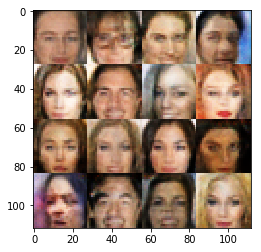

Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.4599
Epoch 0/1... Discriminator Loss: 1.6507... Generator Loss: 0.3624
Epoch 0/1... Discriminator Loss: 1.6274... Generator Loss: 0.3154
Epoch 0/1... Discriminator Loss: 1.6164... Generator Loss: 0.3104
Epoch 0/1... Discriminator Loss: 2.1105... Generator Loss: 0.1603
Epoch 0/1... Discriminator Loss: 1.5289... Generator Loss: 0.3984
Epoch 0/1... Discriminator Loss: 1.7946... Generator Loss: 0.2659
Epoch 0/1... Discriminator Loss: 1.4194... Generator Loss: 0.5338
Epoch 0/1... Discriminator Loss: 2.1461... Generator Loss: 0.1638
Epoch 0/1... Discriminator Loss: 1.2499... Generator Loss: 0.7174
Epoch 0/1... Discriminator Loss: 1.3871... Generator Loss: 0.4523
Epoch 0/1... Discriminator Loss: 1.3922... Generator Loss: 0.4829
Epoch 0/1... Discriminator Loss: 1.2636... Generator Loss: 0.5371
Epoch 0/1... Discriminator Loss: 1.6107... Generator Loss: 0.4657
Epoch 0/1... Discriminator Loss: 2.1665... Generator Loss: 0.1560
Epoch 0/1.

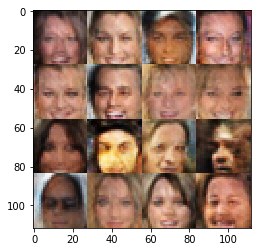

Epoch 0/1... Discriminator Loss: 1.7740... Generator Loss: 0.2647
Epoch 0/1... Discriminator Loss: 1.9484... Generator Loss: 0.1908
Epoch 0/1... Discriminator Loss: 1.5441... Generator Loss: 0.3828
Epoch 0/1... Discriminator Loss: 1.3820... Generator Loss: 0.4349
Epoch 0/1... Discriminator Loss: 1.6373... Generator Loss: 0.3933
Epoch 0/1... Discriminator Loss: 1.5992... Generator Loss: 0.3336
Epoch 0/1... Discriminator Loss: 1.8689... Generator Loss: 0.2744
Epoch 0/1... Discriminator Loss: 1.3930... Generator Loss: 0.4458
Epoch 0/1... Discriminator Loss: 1.8613... Generator Loss: 0.2260
Epoch 0/1... Discriminator Loss: 1.3971... Generator Loss: 0.6955
Epoch 0/1... Discriminator Loss: 1.2248... Generator Loss: 0.7965
Epoch 0/1... Discriminator Loss: 1.5991... Generator Loss: 0.3157
Epoch 0/1... Discriminator Loss: 1.8141... Generator Loss: 0.2976
Epoch 0/1... Discriminator Loss: 1.4580... Generator Loss: 0.5534
Epoch 0/1... Discriminator Loss: 2.1963... Generator Loss: 0.3071
Epoch 0/1.

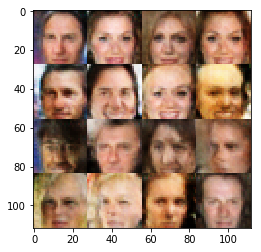

Epoch 0/1... Discriminator Loss: 1.2820... Generator Loss: 0.6225
Epoch 0/1... Discriminator Loss: 1.6228... Generator Loss: 0.3935
Epoch 0/1... Discriminator Loss: 1.4806... Generator Loss: 0.7746
Epoch 0/1... Discriminator Loss: 1.8277... Generator Loss: 0.2542
Epoch 0/1... Discriminator Loss: 1.1946... Generator Loss: 0.6953
Epoch 0/1... Discriminator Loss: 1.6709... Generator Loss: 0.3083
Epoch 0/1... Discriminator Loss: 1.2363... Generator Loss: 0.6492
Epoch 0/1... Discriminator Loss: 1.3707... Generator Loss: 0.4773
Epoch 0/1... Discriminator Loss: 1.4848... Generator Loss: 0.4063
Epoch 0/1... Discriminator Loss: 1.5550... Generator Loss: 0.4256
Epoch 0/1... Discriminator Loss: 1.2879... Generator Loss: 0.6628
Epoch 0/1... Discriminator Loss: 2.8666... Generator Loss: 0.0800
Epoch 0/1... Discriminator Loss: 1.4638... Generator Loss: 0.3992
Epoch 0/1... Discriminator Loss: 1.8288... Generator Loss: 0.2018
Epoch 0/1... Discriminator Loss: 1.5219... Generator Loss: 0.4538
Epoch 0/1.

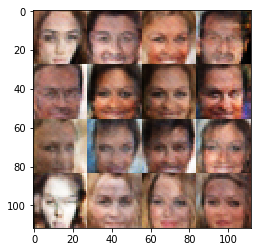

Epoch 0/1... Discriminator Loss: 1.9556... Generator Loss: 0.1837
Epoch 0/1... Discriminator Loss: 1.3102... Generator Loss: 0.9371
Epoch 0/1... Discriminator Loss: 1.3027... Generator Loss: 0.6955
Epoch 0/1... Discriminator Loss: 1.2718... Generator Loss: 0.5046
Epoch 0/1... Discriminator Loss: 1.7459... Generator Loss: 0.2511
Epoch 0/1... Discriminator Loss: 1.6329... Generator Loss: 0.3438
Epoch 0/1... Discriminator Loss: 2.1552... Generator Loss: 0.1581
Epoch 0/1... Discriminator Loss: 1.5579... Generator Loss: 0.4395
Epoch 0/1... Discriminator Loss: 1.7725... Generator Loss: 0.2828
Epoch 0/1... Discriminator Loss: 1.3870... Generator Loss: 0.7346
Epoch 0/1... Discriminator Loss: 1.5077... Generator Loss: 0.3723
Epoch 0/1... Discriminator Loss: 1.9729... Generator Loss: 0.1911
Epoch 0/1... Discriminator Loss: 2.3525... Generator Loss: 0.1315
Epoch 0/1... Discriminator Loss: 1.9871... Generator Loss: 0.2192
Epoch 0/1... Discriminator Loss: 1.4743... Generator Loss: 0.3427
Epoch 0/1.

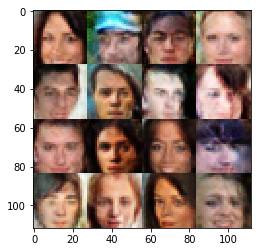

Epoch 0/1... Discriminator Loss: 1.2164... Generator Loss: 0.6046
Epoch 0/1... Discriminator Loss: 1.6323... Generator Loss: 0.3263
Epoch 0/1... Discriminator Loss: 1.5269... Generator Loss: 0.4144
Epoch 0/1... Discriminator Loss: 1.1023... Generator Loss: 0.7768
Epoch 0/1... Discriminator Loss: 1.9174... Generator Loss: 0.2099
Epoch 0/1... Discriminator Loss: 1.0232... Generator Loss: 0.7614
Epoch 0/1... Discriminator Loss: 1.7178... Generator Loss: 0.2641
Epoch 0/1... Discriminator Loss: 1.2093... Generator Loss: 0.6012
Epoch 0/1... Discriminator Loss: 1.4056... Generator Loss: 0.5583
Epoch 0/1... Discriminator Loss: 1.8517... Generator Loss: 0.2326
Epoch 0/1... Discriminator Loss: 1.8198... Generator Loss: 0.2652
Epoch 0/1... Discriminator Loss: 1.4877... Generator Loss: 0.6032
Epoch 0/1... Discriminator Loss: 1.9268... Generator Loss: 0.2044
Epoch 0/1... Discriminator Loss: 1.2967... Generator Loss: 0.5225
Epoch 0/1... Discriminator Loss: 1.5270... Generator Loss: 0.3414
Epoch 0/1.

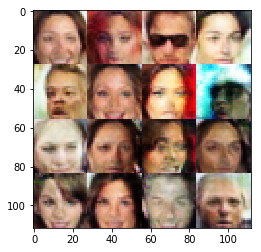

Epoch 0/1... Discriminator Loss: 1.3111... Generator Loss: 0.5014
Epoch 0/1... Discriminator Loss: 2.1976... Generator Loss: 0.1443
Epoch 0/1... Discriminator Loss: 1.2900... Generator Loss: 0.8405
Epoch 0/1... Discriminator Loss: 1.4978... Generator Loss: 0.3205
Epoch 0/1... Discriminator Loss: 2.2724... Generator Loss: 0.1341
Epoch 0/1... Discriminator Loss: 1.7577... Generator Loss: 0.5575
Epoch 0/1... Discriminator Loss: 1.7934... Generator Loss: 0.3237
Epoch 0/1... Discriminator Loss: 1.2643... Generator Loss: 0.6475
Epoch 0/1... Discriminator Loss: 1.9673... Generator Loss: 0.2665
Epoch 0/1... Discriminator Loss: 1.2719... Generator Loss: 0.5255
Epoch 0/1... Discriminator Loss: 1.2798... Generator Loss: 0.9891
Epoch 0/1... Discriminator Loss: 1.7683... Generator Loss: 0.2464
Epoch 0/1... Discriminator Loss: 1.3290... Generator Loss: 1.0389


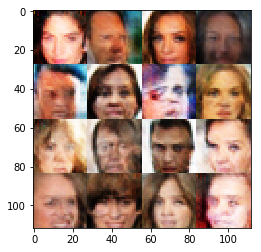

In [15]:
batch_size = 32
z_dim = 1200
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.